Links:

- https://nbviewer.jupyter.org/github/djsegal/SimplePlots.jl/blob/master/binder/covid-19.ipynb

---

In [ ]:
using Measurements

param_error = 0.05

α = 0.2 ± param_error
γ = 0.5 ± param_error

# β = f(social distancing, masks, etc.)

E₀ = 1e-4
u₀ = [ 1 - E₀ ; E₀ ; 0 ; 0 ]

tspan = (0.0, 200.0);  # 200 days

In [ ]:
using DifferentialEquations

function seir!(du,u,p,t)
  S,E,I,_ = u
  α,β,γ = p

  dS = ( -β*I*S )
  dE = ( +β*I*S ) - α*E
  dI = ( -γ*I   ) + α*E
  dR = ( +γ*I   )

  du .= (dS, dE, dI, dR)
end

labels = [
  "Susceptible", "Exposed", 
  "Infected", "Recovered"
];

In [ ]:
using SimplePlots

display(html"""
  <h3> Sliding the β value reduces/increases infectivity </h3>
  <p style="margin-top: 0.4em">(social distancing, immunity, vaccines reduce β)</p>
""")

beta_slider = slider(0.25:0.25:2, value=1, label="β") 

@demo for β in beta_slider
  title!("Covid-19 SEIR Model with Error Bars") ;
  xlabel!("Time (Days)") ; ylabel!("%")  
  
  soln = solve(ODEProblem(
    seir!, u₀, tspan, [α, β ± param_error, γ]
  ), saveat=0.5)
  
  x, y = soln.t, 100*Array(soln)
  ylims!(0, 100) # using percentages
  
  for (index, label) in enumerate(labels)
    plot!(
      x, y[index,:], label=label, 
      alpha=0.8, fillalpha=0.1
    )
  end
end

## Using ReachabilityAnalysis

In [1]:
using ReachabilityAnalysis

In [61]:
@taylorize function seir2!(du,u,p,t)
  S, E, I, R, α, β, γ = u

  βIS = β * (I * S)
  αE = α*E
  γI = γ*I

  du[1] = -βIS      # dS
  du[2] = βIS - αE  # dE
  du[3] = -γI + αE  # dI
  du[4] = γI        # dR

  # uncertain parameters  param_error = 0.05
  local zerou = zero(u[1])
  du[5] = zerou # α = 0.2 ± param_error
  du[6] = zerou # β = 0.5 ± param_error
  du[7] = zerou # γ = 0.5 ± param_error
end

In [62]:
E₀ = 1e-4
u₀ = [1-E₀, E₀, 0, 0]
param_error = 0.001
α = 0.2 ± param_error
β = 0.5 ± param_error
γ = 0.5 ± param_error
p = [α, β, γ]
X0 = IntervalBox(vcat(u₀, p));
prob = @ivp(x' = seir2!(x), dim=7, x(0) ∈ X0);

In [64]:
@time sol = solve(prob, tspan=(0.0, 200.0), alg=TMJets(abs_tol=1e-10, orderT=7, orderQ=1, adaptive=true));

  1.779561 seconds (29.73 M allocations: 2.026 GiB, 25.38% gc time)


In [90]:
solz = overapproximate(sol, Zonotope);
solz = [ReachSet(linear_map(Matrix(100.0I, 7, 7), set(R)), tspan(R)) for R in solz];

In [38]:
using Plots

In [66]:
LazySets.set_ztol(Float64, 1e-12)

1.0e-12

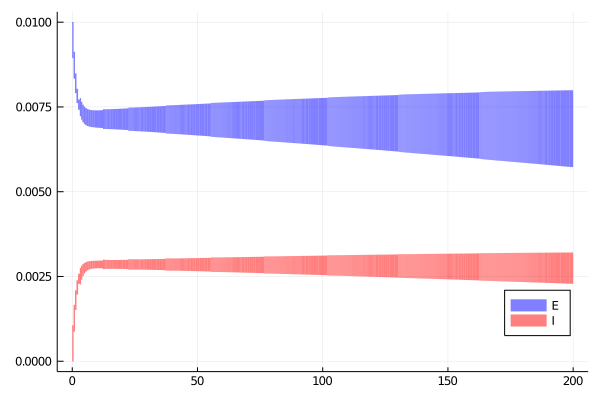

In [91]:
fig = plot(legend=:bottomright)

#plot!(fig, solz, vars=(0, 1), color=:blue, lw=0.0, lab="S")
plot!(fig, solz, vars=(0, 2), color=:blue, lw=0.0, lab="E")
plot!(solz, vars=(0, 3), color=:red, lw=0.0, lab="I")
#plot!(solz, vars=(0, 4), color=:blue, lw=0.0, lab="R")